# Environment

### Downloads

In [1]:
!pip install gym
!pip install "stable-baselines3[extra]>=2.0.0a4"


[notice] A new release of pip is available: 23.3 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Imports

In [2]:
import gym
from gym import Env, spaces
import numpy as np
from stable_baselines3 import PPO

# Utilidad
import json
import copy # Para copiar las variables originales a las que el ambiente edite para cuando se haga un reset
import random

### Funciones útiles

### Definición

In [3]:
preferencias = [
    [1,2,3,0],
    [0,3,2,1],
    [3,2,1,0]
]

state = [
    [0,0,0,0],
    [0,0,0,0],
    [0,0,0,0]
]

observation = [
    preferencias, state
]

In [4]:
class OrganizationEnvironment(gym.Env):
    def __init__(self, preferencias = None, rendering = False):
        super(OrganizationEnvironment, self).__init__()

        self.all_rewards = []
        self.rendering = rendering

        if(preferencias == None):
            self.preferencias = self.get_preferencias()
        else:
            self.preferencias = preferencias

        self.num_estudiantes = len(self.preferencias)
        self.num_desafios = len(self.preferencias[0])

        self.num_preferencias = 0
        for i in self.preferencias:
            for j in i:
                if j > self.num_preferencias:
                    self.num_preferencias = j


        self.state = [[ 0 for _ in range(self.num_desafios)] for _ in range(self.num_estudiantes)]
        self.current_ids = list(range(len(self.preferencias)))
        self.reset()

        # Definición de espacio de observación
        self.observation_space = spaces.MultiDiscrete([2] * (self.num_estudiantes * self.num_desafios) + \
                                                      [self.num_desafios] * (self.num_estudiantes * self.num_desafios))
        # Definición de espacio de acción
        self.action_space = spaces.MultiDiscrete([self.num_estudiantes, self.num_desafios])


    def get_preferencias(self):
        num_estudiantes = 10
        num_desafios = 4

        preferencias_totales = []

        for i in range(num_estudiantes):
            preferencias_estudiante = [0] * (num_desafios)
            numero_preferencia = 1

            while True:
                desafio = random.randint(0, num_desafios - 1)
                if(preferencias_estudiante[desafio] == 0):
                    preferencias_estudiante[desafio] = numero_preferencia
                    numero_preferencia += 1
                if(numero_preferencia > 3):
                    break
            preferencias_totales.append(preferencias_estudiante)

        if(self.rendering):
            print("\t  Preferencias")
            for index, fila in enumerate(preferencias_totales):
                print(f"Alumno {index}: ",fila)

        return preferencias_totales

    def render(self):
        print("\t  Desafíos")
        for index, fila in enumerate(self.state):
            print(f"Alumno {index}: ",fila)

    def reset(self):

        last_observation = self._get_observation()

        self.lives = 3
        self.preferencias = self.get_preferencias()
        self.reward_acumulado = 0
        self.num_estudiantes = len(self.preferencias)
        self.num_desafios = len(self.preferencias[0])

        self.num_preferencias = 0
        for i in self.preferencias:
            for j in i:
                if j > self.num_preferencias:
                    self.num_preferencias = j


        # Espacio de observación
        self.state = [[ 0 for _ in range(self.num_desafios)] for _ in range(self.num_estudiantes)]
        self.current_ids = list(range(len(self.preferencias)))

        return last_observation

    def step(self, action):
        assert self.action_space.contains(action), "Invalid Action"

        id_estudiante = action[0]
        id_desafio = action[1]

        done = self.check_done()

        if self._chech_possible(id_estudiante, id_desafio):

            self.state[id_estudiante][id_desafio] = 1

            if(not done):
                contador_escogidos = 0
                for estudiante in self.state:
                    for desafio in estudiante:
                        contador_escogidos += desafio

            reward = self.get_reward([id_estudiante, id_desafio])

        else:
            self.lives -= 1
            reward = -8

        self.reward_acumulado += reward
        if not(self.lives > 0):
            done = True
        # observation = [self.state, self.preferencias]
        observation = self._get_observation()
        info = {}

        if done:
            self.all_rewards.append(self.reward_acumulado)
            return observation, self.reward_acumulado, done, info
        return observation, reward, done, info


    def _chech_possible(self, id_estudiante, id_desafio):
        # Ver si el estudiante ya esta dentro de un desafío
        total_desafios_asignados = 0
        for desafio_estudiante in self.state[id_estudiante]:
            total_desafios_asignados += desafio_estudiante
        if(total_desafios_asignados > 0):
            return False

        return True

    def _get_observation(self):
        # Aplanar el estado y las preferencias para ajustarse al espacio de observación
        return [self.state[i][j] for i in range(self.num_estudiantes) for j in range(self.num_desafios)] + \
               [self.preferencias[i][j] for i in range(self.num_estudiantes) for j in range(self.num_desafios)]

    def get_reward(self, action):
        id_estudiante = action[0]
        id_desafio = action[1]

        reward = 0
        # Reward por las preferencias
        reward +=   (self.num_preferencias - self.preferencias[id_estudiante][id_desafio] + 1) * 2 \
                    if self.preferencias[id_estudiante][id_desafio] != 0 \
                    else -5


        # Reward

        # Implementar función de reward
        return reward

    def check_done(self):
        # Condición para finalizar el episodio
        contador_de_estudiantes = 0
        for estudiante in self.state:
            for seleccion in estudiante:
                contador_de_estudiantes += seleccion

        if(contador_de_estudiantes == self.num_estudiantes):
            return True

        return False

env = OrganizationEnvironment()

In [5]:
env.reset()
while True:
    action = env.action_space.sample()

    obs, reward, done, info = env.step(action)

    env.render()

    if done == True:
        break

# print(binary_to_dict2(obs))

	  Desafíos
Alumno 0:  [0, 0, 0, 0]
Alumno 1:  [0, 0, 0, 0]
Alumno 2:  [0, 0, 0, 0]
Alumno 3:  [0, 0, 0, 0]
Alumno 4:  [0, 0, 0, 0]
Alumno 5:  [0, 0, 0, 0]
Alumno 6:  [0, 0, 0, 0]
Alumno 7:  [0, 0, 0, 0]
Alumno 8:  [0, 1, 0, 0]
Alumno 9:  [0, 0, 0, 0]
	  Desafíos
Alumno 0:  [0, 0, 0, 0]
Alumno 1:  [0, 1, 0, 0]
Alumno 2:  [0, 0, 0, 0]
Alumno 3:  [0, 0, 0, 0]
Alumno 4:  [0, 0, 0, 0]
Alumno 5:  [0, 0, 0, 0]
Alumno 6:  [0, 0, 0, 0]
Alumno 7:  [0, 0, 0, 0]
Alumno 8:  [0, 1, 0, 0]
Alumno 9:  [0, 0, 0, 0]
	  Desafíos
Alumno 0:  [0, 1, 0, 0]
Alumno 1:  [0, 1, 0, 0]
Alumno 2:  [0, 0, 0, 0]
Alumno 3:  [0, 0, 0, 0]
Alumno 4:  [0, 0, 0, 0]
Alumno 5:  [0, 0, 0, 0]
Alumno 6:  [0, 0, 0, 0]
Alumno 7:  [0, 0, 0, 0]
Alumno 8:  [0, 1, 0, 0]
Alumno 9:  [0, 0, 0, 0]
	  Desafíos
Alumno 0:  [0, 1, 0, 0]
Alumno 1:  [0, 1, 0, 0]
Alumno 2:  [0, 0, 0, 0]
Alumno 3:  [0, 0, 0, 0]
Alumno 4:  [1, 0, 0, 0]
Alumno 5:  [0, 0, 0, 0]
Alumno 6:  [0, 0, 0, 0]
Alumno 7:  [0, 0, 0, 0]
Alumno 8:  [0, 1, 0, 0]
Alumno 9:  [0, 0

In [6]:
env.observation_space.sample()

array([1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 3, 3, 2, 0,
       3, 3, 1, 1, 3, 0, 1, 1, 1, 0, 1, 0, 3, 1, 1, 2, 0, 2, 0, 0, 0, 0,
       3, 1, 2, 1, 3, 3, 2, 3, 2, 0, 1, 1, 1, 0], dtype=int64)

Entrenamiento

In [7]:
env = OrganizationEnvironment(rendering=False)
model = PPO("MlpPolicy", env).learn(total_timesteps=10_000)

# print(binary_to_dict(obs))

c:\Users\salb7\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


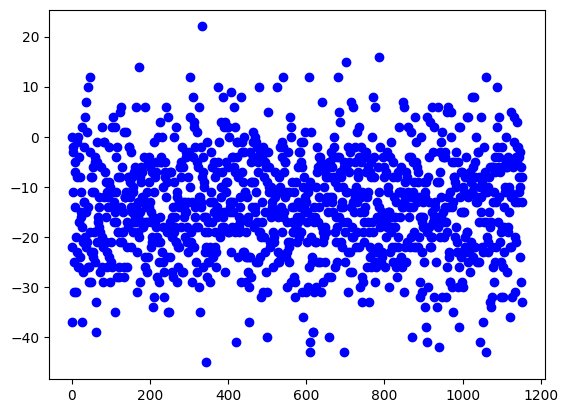

In [8]:
import matplotlib.pyplot as plt

x = list(range(len(env.all_rewards)))
y = env.all_rewards

plt.scatter(x, y, c ="blue")

plt.show()

In [9]:
len(env.all_rewards)

1154

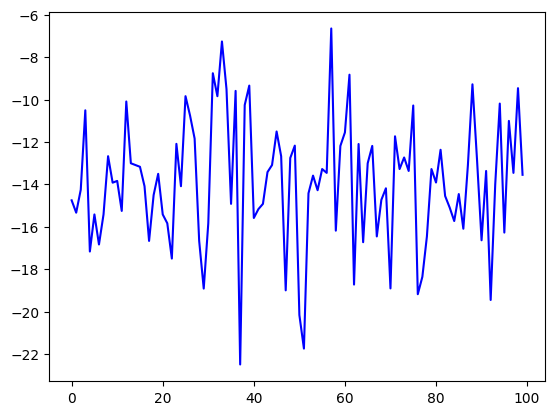

In [10]:
# Divide la lista en 100 sublistas
sublistas = np.array_split(env.all_rewards, 100)

# Calcula la media de cada sublista y guarda en una nueva lista
medias = [np.mean(sublista) for sublista in sublistas]

x = list(range(len(medias)))
y = medias

plt.plot(x, y, c ="blue")

plt.show()


In [11]:
print(env.all_rewards)

[0, -37, -22, -3, -11, -2, -31, -25, -14, -5, -7, -20, -31, -23, -8, -1, -26, 0, -17, -26, -4, -8, -24, -16, -15, -11, -18, -37, 2, -21, -27, -13, -13, -2, 4, -20, -15, -22, 7, -21, 1, -14, -26, 10, -26, -29, -3, 12, -19, -23, -29, -8, -8, -11, -6, -23, -24, -11, -19, -25, -5, -4, -33, -39, -1, -21, -5, -16, -17, -18, -12, -14, -21, -27, -19, -21, -6, -26, 2, -20, -29, -22, -12, -1, -1, -7, -21, -16, -9, -21, -26, -11, -23, -12, -14, -24, -9, -2, -10, -29, -25, -11, -21, -26, 2, -14, 4, -11, -13, -17, -35, 2, -15, -11, -4, -17, -28, -2, -19, -8, -19, -26, -28, -21, 5, -8, 6, -14, -19, -21, -6, -15, -19, -28, -26, 1, -12, -12, -12, -11, 1, -17, -26, -22, -18, -8, -8, -2, -2, -12, -9, -3, -14, -22, -15, -8, -10, -19, -11, -17, -14, -7, -16, -6, -17, -14, 6, -31, -23, -13, -19, -16, 14, -20, -15, -29, -8, -6, -9, -13, -12, -7, -17, -12, -18, -4, -13, 6, -24, -26, -14, -17, -11, -27, -17, -24, -5, -4, -9, -14, -6, -13, -17, -22, -15, -21, -7, -20, -16, -34, -1, -11, -32, -8, -17, -18, -5, 

In [12]:
# env = OrganizationEnvironment(rendering=True)
obs = env.reset()

while True:
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    env.render()
    print(reward)
    if done == True:
        break

	  Desafíos
Alumno 0:  [0, 1, 0, 0]
Alumno 1:  [0, 0, 0, 0]
Alumno 2:  [0, 0, 0, 0]
Alumno 3:  [0, 0, 0, 0]
Alumno 4:  [0, 0, 0, 0]
Alumno 5:  [0, 0, 0, 0]
Alumno 6:  [0, 0, 0, 0]
Alumno 7:  [0, 0, 0, 0]
Alumno 8:  [0, 0, 0, 0]
Alumno 9:  [0, 0, 0, 0]
-5
	  Desafíos
Alumno 0:  [0, 1, 0, 0]
Alumno 1:  [0, 0, 0, 0]
Alumno 2:  [0, 0, 0, 0]
Alumno 3:  [0, 0, 0, 0]
Alumno 4:  [0, 0, 0, 1]
Alumno 5:  [0, 0, 0, 0]
Alumno 6:  [0, 0, 0, 0]
Alumno 7:  [0, 0, 0, 0]
Alumno 8:  [0, 0, 0, 0]
Alumno 9:  [0, 0, 0, 0]
6
	  Desafíos
Alumno 0:  [0, 1, 0, 0]
Alumno 1:  [0, 0, 0, 0]
Alumno 2:  [0, 0, 0, 0]
Alumno 3:  [0, 0, 0, 0]
Alumno 4:  [0, 0, 0, 1]
Alumno 5:  [0, 0, 0, 0]
Alumno 6:  [0, 0, 0, 0]
Alumno 7:  [0, 0, 0, 0]
Alumno 8:  [0, 0, 0, 0]
Alumno 9:  [0, 0, 0, 0]
-8
	  Desafíos
Alumno 0:  [0, 1, 0, 0]
Alumno 1:  [0, 0, 0, 0]
Alumno 2:  [0, 0, 0, 0]
Alumno 3:  [0, 0, 0, 0]
Alumno 4:  [0, 0, 0, 1]
Alumno 5:  [0, 0, 0, 0]
Alumno 6:  [0, 0, 0, 0]
Alumno 7:  [1, 0, 0, 0]
Alumno 8:  [0, 0, 0, 0]
Alumno 9

# Algorithm

In [28]:
def splitt(alumno, pref):
   return [alumno[i:i + pref] for i in range(0, len(alumno), pref)]

def algoritmo_action(obs):
  l1 = obs[:40]
  l2 = obs[40:]
  n_pref = splitt(l1, 4)
  w_pref = splitt(l2, 4)

  for i, r in enumerate(n_pref):
     print(f"alumno {i} sin preferencias: ", r)
  print("\t")
  for i, r in enumerate(w_pref):
     print(f"alumno {i} con preferencias: ", r)
  
  return action

env.reset()
obs = env._get_observation()

while True:
    action = algoritmo_action(obs)
    obs, reward, done, info = env.step(action)
    env.render()
    print(reward)
    if done == True:
        break

alumno 0 sin preferencias:  [0, 0, 0, 0]
alumno 1 sin preferencias:  [0, 0, 0, 0]
alumno 2 sin preferencias:  [0, 0, 0, 0]
alumno 3 sin preferencias:  [0, 0, 0, 0]
alumno 4 sin preferencias:  [0, 0, 0, 0]
alumno 5 sin preferencias:  [0, 0, 0, 0]
alumno 6 sin preferencias:  [0, 0, 0, 0]
alumno 7 sin preferencias:  [0, 0, 0, 0]
alumno 8 sin preferencias:  [0, 0, 0, 0]
alumno 9 sin preferencias:  [0, 0, 0, 0]
	
alumno 0 con preferencias:  [2, 3, 0, 1]
alumno 1 con preferencias:  [1, 2, 0, 3]
alumno 2 con preferencias:  [2, 1, 0, 3]
alumno 3 con preferencias:  [2, 3, 0, 1]
alumno 4 con preferencias:  [2, 0, 1, 3]
alumno 5 con preferencias:  [1, 2, 0, 3]
alumno 6 con preferencias:  [0, 1, 3, 2]
alumno 7 con preferencias:  [3, 0, 1, 2]
alumno 8 con preferencias:  [0, 3, 1, 2]
alumno 9 con preferencias:  [1, 2, 3, 0]
	  Desafíos
Alumno 0:  [0, 0, 0, 1]
Alumno 1:  [0, 0, 0, 0]
Alumno 2:  [0, 0, 0, 0]
Alumno 3:  [0, 0, 0, 0]
Alumno 4:  [0, 0, 0, 0]
Alumno 5:  [0, 0, 0, 0]
Alumno 6:  [0, 0, 0, 0